# GAIA PSF Simulation

First attempt to simulate close binary stars observation using the gaia telescope. The latter is imagined as a rectangular pupil, with no pixel binning or aberrations

#### Initialization

In [1]:
# %matplotlib qt
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
import poppy
from xupy import typings as xt
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
from matplotlib import pyplot as plt
from bincatsim.simulator import GaiaSimulator
from bincatsim.instruments import CCD
from bincatsim.core import root

Gpb = QTable.read(root.PASSBAND_FILE)
weights = Gpb.filled(0)

def rebinned(psf: fits.HDUList | xt.ArrayLike, rebin_factor: int, axis_ratio: tuple[int,int] = (1,1)) -> fits.HDUList:
    """
    Rebin PSF by a given factor, following Gaia's pixel scale (1:3 ratio).
    """
    if isinstance(psf, fits.HDUList):
        psf = psf[0].data
    px_ratio = (rebin_factor*axis_ratio[0], rebin_factor*axis_ratio[1])
    return poppy.utils.rebin_array(psf, px_ratio)

```py
poppy.conf.n_processes = 20
poppy.conf.use_cupy = False
poppy.conf.use_multiprocessing = False
poppy.conf.double_precision = False

M1 = poppy.RectangleAperture(name="Primary Mirror", height=1.45*u.m, width=0.5*u.m)
# M2 = poppy.RectangleAperture(name="Beam Collimator / Secondary Mirror",width=0.35*u.m, height=0.2*u.m)
telescope = poppy.OpticalSystem(name="Gaia", oversample=1, verbose=True)

telescope.add_pupil(M1)
telescope.add_detector(name="SkyPLANE", pixelscale=0.001*(u.arcsec/u.pixel), fov_pixels=(2124,1062), oversample=1)

psf = telescope.calc_psf(progressbar=True, return_final=True, source={'wavelengths': Gpb['lambda'], 'weights': weights['G']})

poppy.utils.display_psf(psf[0], title="Gaia PSF", vmax=psf[0][0].data.max())
psf[0].writeto("data/simulations/PSFs/20250923_3_gaia_psf_T.fits", overwrite=True)

## Got The PSF: Now on to the convolution

#### Creating the **Binary Star System (BSS)** and the **CCD**

INFO:root:[CCD] PSF Loaded
INFO:root:[GaiaSimulator] Binary System map shape set to (2124, 1062) pixels.
INFO:root:[GaiaSimulator] Configurations spanning 0-360.0 deg degrees.
INFO:root:[GaiaSimulator] Angular separation set to 200 mas.
INFO:root:[GaiaSimulator] Central star magnitude: 2 mag.
INFO:root:[GaiaSimulator] Companion star magnitude: 2 mag.
INFO:root:[GaiaSimulator] Calibration G-Magnitude of the single source: 1.2474250108400469 mag.
INFO:root:[GaiaSimulator] Central star flux: [2714.2602229] photons/s/cm².
INFO:root:[GaiaSimulator] Companion star flux: [2714.2602229] photons/s/cm².
INFO:root:[GaiaSimulator] Base map with central star created.


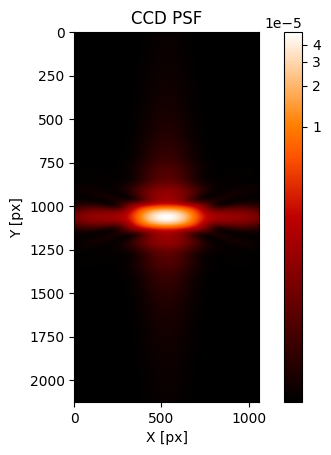

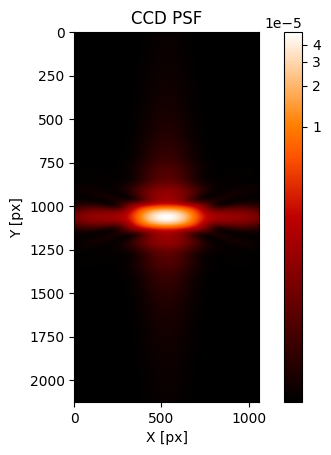

In [5]:
ccd = CCD(psf=os.path.join(root.PSF_DATA_PATH, '1062x2124_gpsf_T.fits'), pixel_scale_x = 177*u.mas, pixel_scale_y = 59*u.mas)
bs = GaiaSimulator(ccd=ccd, M1=2, M2=2, distance=200, angle=360)

ccd.display_psf()

In [ ]:
rbfactor = int(ccd.pxscale_y.value)
ratio = int(1/ccd.pxscale_factor)
rbratio = (rbfactor * ratio, rbfactor)
print(rbratio)

In [ ]:
map = bs.show_system(out=True, origin='lower', xlim=(330,732), ylim=(861,1263))

In [ ]:
ring = bs._create_ring(200)

sx,sy = ring.shape
cx,cy = sx//2, sy//2

ring[cx,cy] = True
bmap = bs._create_base_map()

bmap[ring==True] = 1.0

plt.figure(figsize=(16,10))
plt.imshow(bmap, origin='lower', cmap='inferno')
plt.title("Binary system full configurations")
plt.xlabel("X [mas]")
plt.ylabel("Y [mas]")
plt.xlim(330,732)
plt.ylim(861,1263)

In [1]:
from bincatsim.main import main

main(5, 8, 250, 90)


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 5080 Laptop GPU`
       Memory = 16220.22 MB | Compute Capability = 12.0
       Using CuPy 13.6.0 for acceleration.


/home/pietrof/miniforge3/envs/bincat/lib/python3.13/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
[20260114_144149] Observing...: 100%|██████████| 392/392 [01:41<00:00,  3.88images/s]
